In [1]:
from google.colab import files
import io
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from keras.utils import plot_model
import plotly.express as pl
import random
import matplotlib.pyplot as plt
import seaborn as sns

!pip3 install keras_lr_finder
from sklearn.model_selection import KFold
from keras_lr_finder import LRFinder

# Upload file

In [2]:
uploaded = files.upload()

Saving test.json to test.json
Saving train.json to train.json


# Preprocessing

In [3]:
pred_cols = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']

In [4]:
input_cols = ['sequence', 'structure', 'predicted_loop_type']

In [5]:
train = pd.read_json(io.BytesIO(uploaded['train.json']), lines=True).drop('index', axis=1)
test = pd.read_json(io.BytesIO(uploaded['test.json']), lines=True).drop('index', axis=1)

In [6]:
train = train.query("signal_to_noise >= 1")

In [7]:
train = train.query("SN_filter == 1")

In [8]:
test_private = test.query("seq_length == 130")

In [9]:
test_public = test.query("seq_length == 107")

In [10]:
train.head()

,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
5,id_00ab2d761,GGAAAGCGCCGCGGCGGUAGCGGCAGCGAGGAGCGCUACCAAGGCA...,.....(.(((((.(((((((((...........)))))))..(((....,EEEEESISSSSSISSSSSSSSSHHHHHHHHHHHSSSSSSSMMSSSH...,4.136,1,107,68,"[0.1942, 0.2041, 0.1626, 0.1213, 0.10590000000...","[0.2726, 0.2984, 0.21660000000000001, 0.1637, ...","[0.3393, 0.2728, 0.2005, 0.1703, 0.1495, 0.134...","[0.165, 0.20520000000000002, 0.179, 0.1333, 0....","[0.2864, 0.24710000000000001, 0.2222, 0.1903, ...","[0.7642, 1.6641, 1.0622, 0.5008, 0.4107, 0.133...","[0.9559000000000001, 1.9442, 1.0114, 0.5105000...","[1.9554, 2.1298, 1.0403, 0.609, 0.5486, 0.386,...","[0.22460000000000002, 1.7281, 1.381, 0.6623, 0...","[0.5882000000000001, 1.1786, 0.9704, 0.6035, 0..."
6,id_00abef1d7,GGAAAACAAUUGCAUCGUUAGUACGACUCCACAGCGUAAGCUGUGG...,.........((((((((......((((((((((((....)))))))...,EEEEEEEEESSSSSSSSIIIIIISSSSSSSSSSSSHHHHSSSSSSS...,2.485,1,107,68,"[0.422, 0.5478000000000001, 0.4749000000000000...","[0.4801, 0.7943, 0.42160000000000003, 0.397300...","[0.9822000000000001, 1.272, 0.6940000000000001...","[0.5827, 0.7555000000000001, 0.5949, 0.4511, 0...","[0.9306000000000001, 1.0496, 0.5844, 0.7796000...","[0.895, 2.3377, 2.2305, 2.003, 1.9006, 1.0373,...","[0.46040000000000003, 3.6695, 0.78550000000000...","[2.7711, 7.365, 1.6924000000000001, 1.43840000...","[1.073, 2.8604000000000003, 1.9936, 1.0273, 1....","[2.0964, 3.3688000000000002, 0.6399, 2.1053, 1..."
7,id_00b436dec,GGAAAUCAUCGAGGACGGGUCCGUUCAGCACGCGAAAGCGUCGUGA...,.....(((((((((((..(((((((((..((((....))))..)))...,EEEEESSSSSSSSSSSIISSSSSSSSSIISSSSHHHHSSSSIISSS...,1.727,1,107,68,"[0.4843, 0.5233, 0.4554, 0.43520000000000003, ...","[0.8719, 1.0307, 0.6649, 0.34500000000000003, ...","[0.7045, 0.7775000000000001, 0.5662, 0.4561, 0...","[0.384, 0.723, 0.4766, 0.30260000000000004, 0....","[0.7429, 0.9137000000000001, 0.480400000000000...","[1.1576, 1.5137, 1.3382, 1.5622, 1.2121, 0.295...","[1.6912, 5.2652, 2.3901, 0.45890000000000003, ...","[1.8641, 2.3767, 1.149, 1.0132, 0.9876, 0.0, 0...","[0.49060000000000004, 4.6339, 1.95860000000000...","[1.2852000000000001, 2.5460000000000003, 0.234..."


In [11]:
def preprocess_inputs(df,input_cols):
    """
    Converts inputs into one-hot
    """
    output = []
    for i in range(len(input_cols)):
        tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
        tokenizer.fit_on_texts(np.asarray(df[input_cols[i]]))
        tmp = tokenizer.texts_to_sequences(np.asarray(df[input_cols[i]]))
        new_var = np.asarray(keras.utils.to_categorical(tmp)[:,:,1:])
        if new_var.shape[1] != 130:
            longer = np.full((new_var.shape[0], 130, new_var.shape[2]), np.float32(0))
            for seq_index in range(len(new_var)):
                tmp = new_var[seq_index]
                row_len = len(tmp[0])
                new_line = np.full(row_len, -10, np.float32)
                while len(tmp) != 130:
                    tmp = np.vstack((tmp, new_line))
                longer[seq_index] = tmp
        output.append(longer)
    return output

In [12]:
inputs = preprocess_inputs(train,input_cols)

In [13]:
inputs[0][0][60:]

array([[  0.,   0.,   0.,   1.],
       [  1.,   0.,   0.,   0.],
       [  0.,   0.,   1.,   0.],
       [  0.,   0.,   1.,   0.],
       [  1.,   0.,   0.,   0.],
       [  0.,   1.,   0.,   0.],
       [  0.,   0.,   1.,   0.],
       [  1.,   0.,   0.,   0.],
       [  0.,   1.,   0.,   0.],
       [  0.,   0.,   0.,   1.],
       [  0.,   0.,   0.,   1.],
       [  1.,   0.,   0.,   0.],
       [  0.,   1.,   0.,   0.],
       [  1.,   0.,   0.,   0.],
       [  0.,   1.,   0.,   0.],
       [  0.,   0.,   0.,   1.],
       [  0.,   0.,   0.,   1.],
       [  0.,   0.,   1.,   0.],
       [  0.,   1.,   0.,   0.],
       [  0.,   0.,   1.,   0.],
       [  0.,   0.,   0.,   1.],
       [  0.,   0.,   1.,   0.],
       [  0.,   0.,   0.,   1.],
       [  1.,   0.,   0.,   0.],
       [  1.,   0.,   0.,   0.],
       [  0.,   0.,   1.,   0.],
       [  1.,   0.,   0.,   0.],
       [  1.,   0.,   0.,   0.],
       [  1.,   0.,   0.,   0.],
       [  1.,   0.,   0.,   0.],
       [  

In [14]:
def merge_inputs(inputs):
    """
    Merges the one-hot inputs by columns
    Also snips seq length's till desired amount
    """
    size = len(inputs[0])
    output = []
    for i in range(size):
        output.append(np.concatenate((inputs[0][i], inputs[1][i], inputs[2][i]), axis = 1))
    return np.asarray(output)

In [15]:
inputs_simple = merge_inputs(inputs)

In [16]:
inputs_simple.shape

(1587, 130, 14)

In [17]:
test1 = np.zeros((2,5,5))

In [18]:
test1[1,1,0:3]

array([0., 0., 0.])

In [19]:
def preprocess_results(df, results):
    """
    Makes sure that the results are in the appropriate format:
        [layers,lines,columns] in an np array
    """
    tmp = np.asarray(df[results])
    size = len(tmp[0])
    output = np.zeros((len(tmp),len(tmp[0][0]),len(results)))
    for i in range(len(results)):
        for j in range(size):
            tmp[i,j] = np.asarray(tmp[i,j])
    for i in range(len(tmp)):
        output[i] = np.vstack((tmp[i,0], tmp[i,1], tmp[i,2]))[:,:].T
    return output

In [20]:
expected_results = preprocess_results(train, pred_cols)

In [21]:
expected_results.shape

(1587, 68, 3)

In [22]:
expected_results[0,0]

array([0.3297, 0.7556, 0.3581])

In [23]:
inputs_simple

array([[[  0.,   1.,   0., ...,   0.,   0.,   0.],
        [  0.,   1.,   0., ...,   0.,   0.,   0.],
        [  1.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [-10., -10., -10., ..., -10., -10., -10.],
        [-10., -10., -10., ..., -10., -10., -10.],
        [-10., -10., -10., ..., -10., -10., -10.]],

       [[  0.,   1.,   0., ...,   0.,   0.,   0.],
        [  0.,   1.,   0., ...,   0.,   0.,   0.],
        [  1.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [-10., -10., -10., ..., -10., -10., -10.],
        [-10., -10., -10., ..., -10., -10., -10.],
        [-10., -10., -10., ..., -10., -10., -10.]],

       [[  0.,   1.,   0., ...,   0.,   0.,   0.],
        [  0.,   1.,   0., ...,   0.,   0.,   0.],
        [  1.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [-10., -10., -10., ..., -10., -10., -10.],
        [-10., -10., -10., ..., -10., -10., -10.],
        [-10., -10., -10., ..., -10., -10., -10.]],

       ...,

       [[  0.,   1.,   0

In [24]:
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=(0, 1))
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=-1)

# Reseau dense simple

In [25]:
model_simple = keras.Sequential()

model_simple.add(keras.layers.Dense(60, activation=('relu'), input_shape=(68,14)))
model_simple.add(keras.layers.Dense(40, activation=('relu')))
model_simple.add(keras.layers.Dropout(rate=0.4))
model_simple.add(keras.layers.Dense(20, activation=('relu')))
model_simple.add(keras.layers.Dropout(rate=0.4))
model_simple.add(keras.layers.Dense(16, activation='relu'))
model_simple.add(keras.layers.Dropout(rate=0.4))
model_simple.add(keras.layers.Dense(10, activation='relu'))
model_simple.add(keras.layers.Dropout(rate=0.4))


model_simple.add(keras.layers.Dense(3, activation='linear'))

model_simple.compile(loss='mean_squared_error', optimizer='adam', metrics=[MCRMSE])
model_simple.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 68, 60)            900       
_________________________________________________________________
dense_1 (Dense)              (None, 68, 40)            2440      
_________________________________________________________________
dropout (Dropout)            (None, 68, 40)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 68, 20)            820       
_________________________________________________________________
dropout_1 (Dropout)          (None, 68, 20)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 68, 16)            336       
_________________________________________________________________
dropout_2 (Dropout)          (None, 68, 16)            0

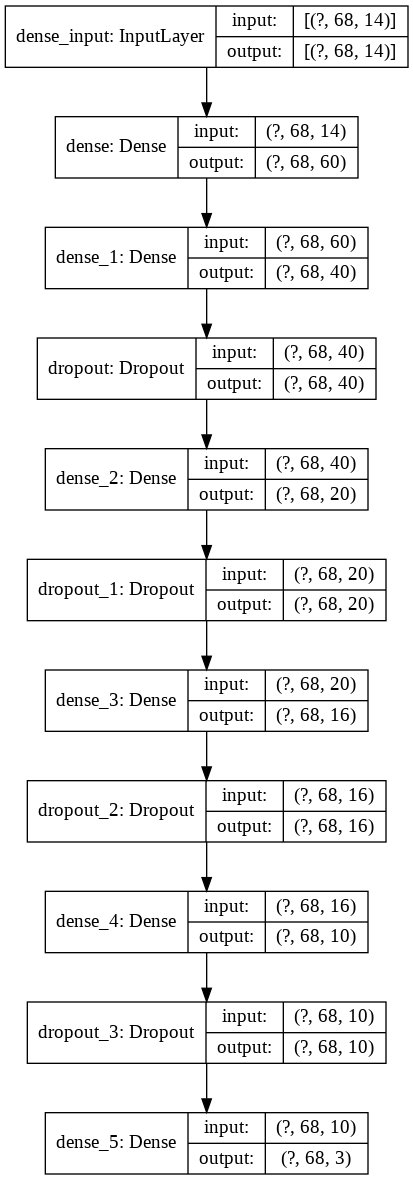

In [26]:
plot_model(model_simple, show_shapes=True)

In [27]:
callback = [tf.keras.callbacks.ModelCheckpoint('simple_model.h5')]

simple_history = model_simple.fit(inputs_simple[:,:68], expected_results[:,:], batch_size=100, 
                 epochs=100, verbose=1, validation_split=0.2, callbacks = callback
                 ) # validation loss keeps going down?

Epoch 1/100
13/13 [==============================] - 0s 25ms/step - loss: 0.4035 - MCRMSE: 0.6301 - val_loss: 0.3641 - val_MCRMSE: 0.6045
Epoch 2/100
13/13 [==============================] - 0s 9ms/step - loss: 0.3491 - MCRMSE: 0.5895 - val_loss: 0.3113 - val_MCRMSE: 0.5594
Epoch 3/100
13/13 [==============================] - 0s 9ms/step - loss: 0.3216 - MCRMSE: 0.5670 - val_loss: 0.2921 - val_MCRMSE: 0.5417
Epoch 4/100
13/13 [==============================] - 0s 8ms/step - loss: 0.3044 - MCRMSE: 0.5514 - val_loss: 0.2783 - val_MCRMSE: 0.5286
Epoch 5/100
13/13 [==============================] - 0s 9ms/step - loss: 0.2901 - MCRMSE: 0.5378 - val_loss: 0.2644 - val_MCRMSE: 0.5153
Epoch 6/100
13/13 [==============================] - 0s 9ms/step - loss: 0.2795 - MCRMSE: 0.5284 - val_loss: 0.2554 - val_MCRMSE: 0.5065
Epoch 7/100
13/13 [==============================] - 0s 9ms/step - loss: 0.2694 - MCRMSE: 0.5186 - val_loss: 0.2449 - val_MCRMSE: 0.4960
Epoch 8/100
13/13 [=====================

In [28]:
simple_predict = model_simple.predict(inputs_simple[:,:68])

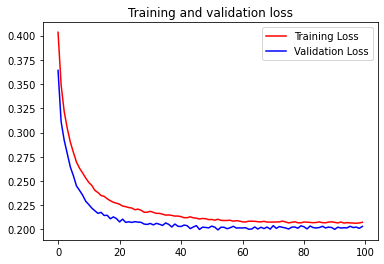

In [29]:
loss = simple_history.history['loss']
val_loss = simple_history.history['val_loss']
epochs = range(len(loss))
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



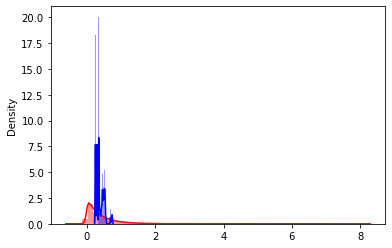

In [30]:
sns.distplot(expected_results[:,:,:], color = 'red')
sns.distplot(simple_predict, color='blue')
plt.show()

# CNN simple

In [31]:
def Conv_block(filter_num, inputs):
    features = keras.layers.Conv1D(filters=filter_num, kernel_size=3, activation=('relu'), 
                                     padding='same')(inputs)
    features = keras.layers.Conv1D(filters=filter_num-2, kernel_size=3, activation=('relu'), 
                                     padding='same')(features)
    features = keras.layers.Conv1D(filters=filter_num-4, kernel_size=3, activation=('relu'), 
                                     padding='same')(features)
    features = keras.layers.MaxPooling1D(pool_size = 2)(features)
    return features

In [32]:
opt = tf.optimizers.Adam(learning_rate=0.001) #default = 0.001

inputs = keras.layers.Input(shape=(130,14))

features = Conv_block(128, inputs)
features = Conv_block(108, features)
features = Conv_block(88, features)
features = Conv_block(68, features)
features = Conv_block(48, features)


flat = keras.layers.GlobalMaxPooling1D()(features)



features = keras.layers.Dense(20, activation=('relu'))(flat)
features = keras.layers.Dropout(rate=0.3)(features)

features = features[:, :68]

first_pred = keras.layers.Dense(1, name="reactivity")(features) #regression pour "reactivity"

second_pred = keras.layers.Dense(1, name="deg_Mg_pH10")(features)  #regression pour "ph"

third_pred = keras.layers.Dense(1, name="deg_Mg_50C")(features)



CNN_model = keras.Model(
    inputs=inputs,
    outputs=[first_pred, second_pred, third_pred],
)
CNN_model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mse'])
CNN_model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 130, 14)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 130, 128)     5504        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 130, 126)     48510       conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 130, 124)     46996       conv1d_1[0][0]                   
_______________________________________________________________________________________

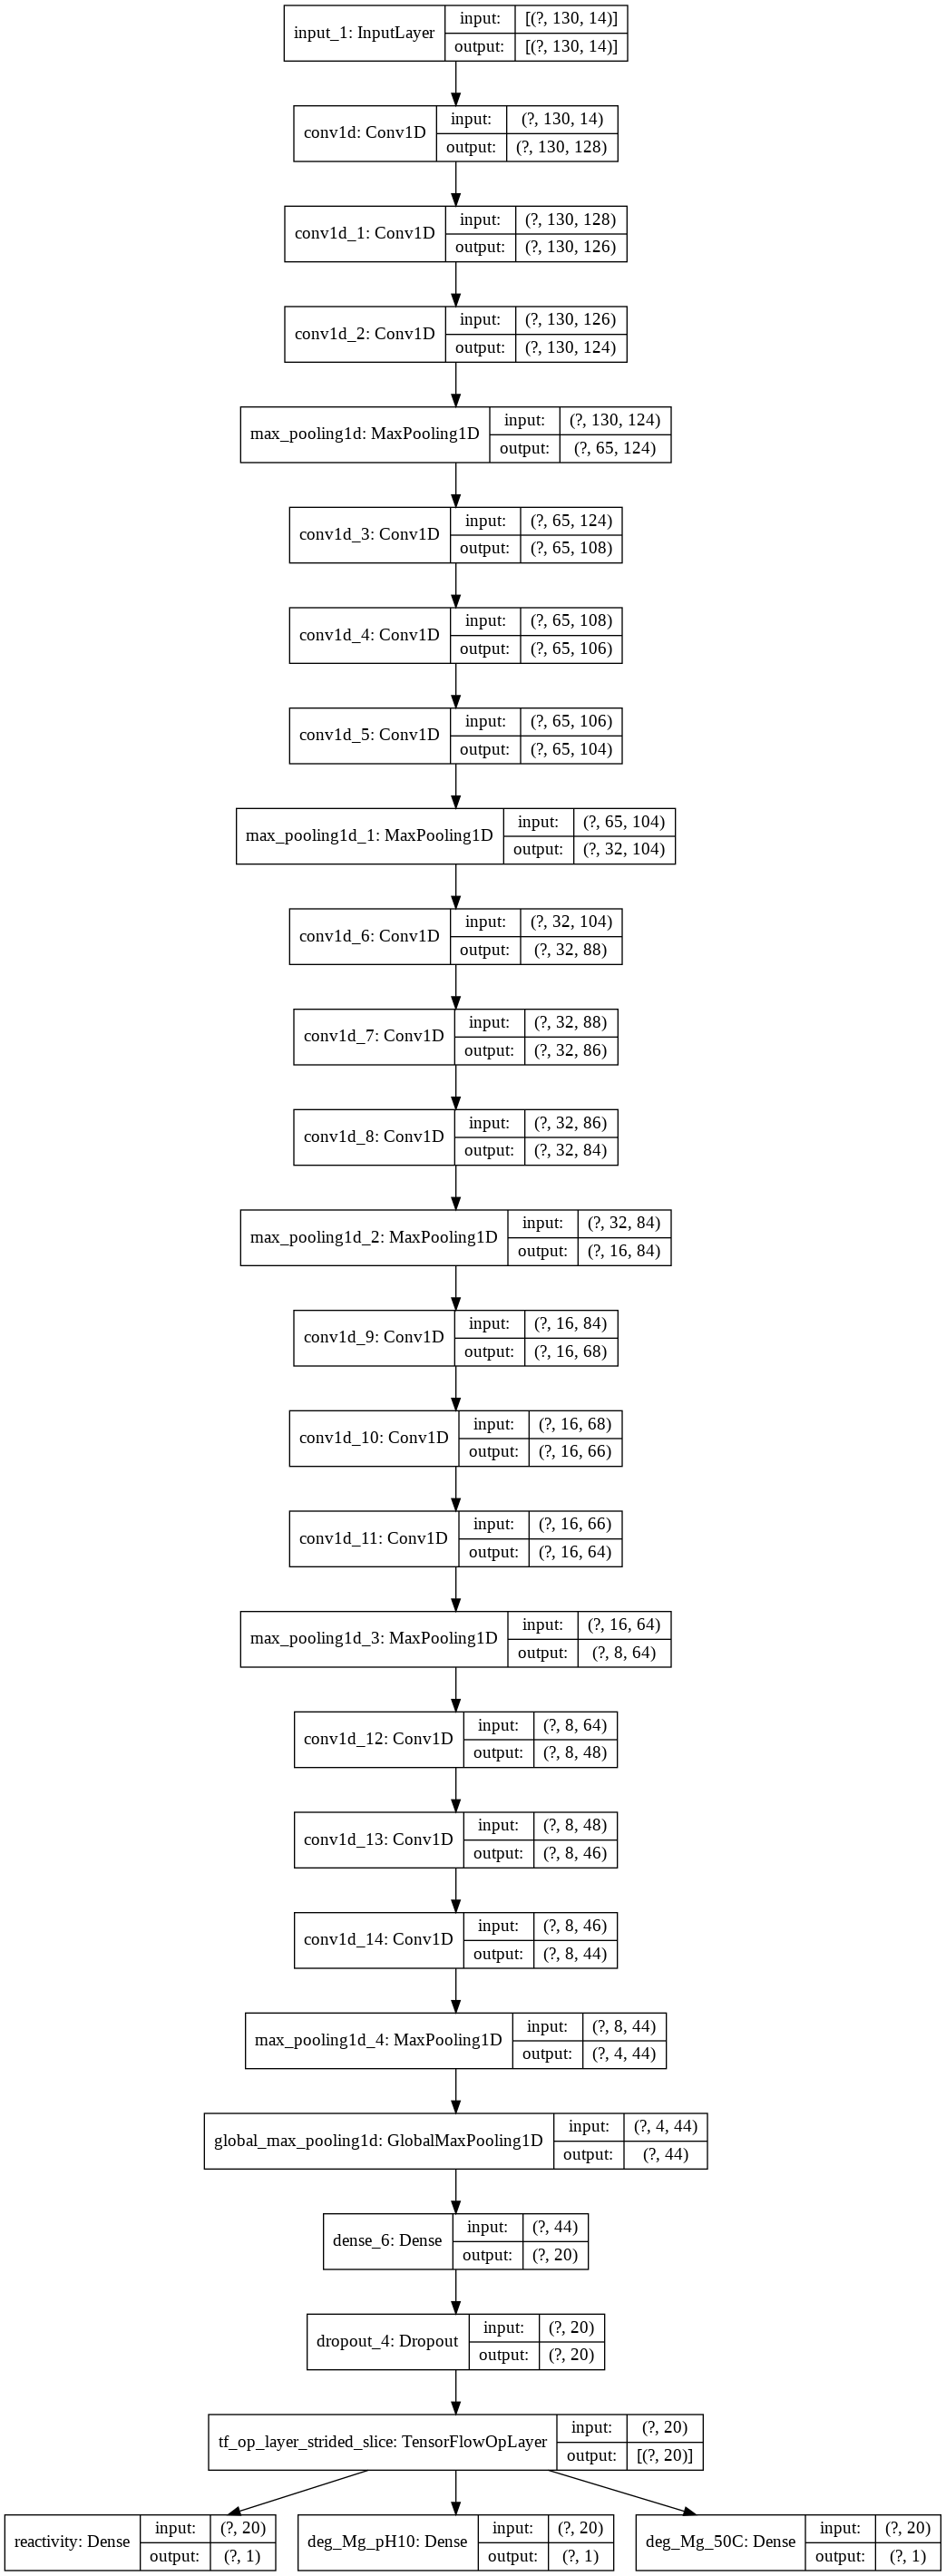

In [33]:
plot_model(CNN_model, show_shapes=True)

In [34]:
inputs_simple.shape

(1587, 130, 14)

In [35]:
CNN_history = CNN_model.fit(inputs_simple,[expected_results[:,:,0], expected_results[:,:,1], expected_results[:,:,2]],
                            batch_size = 66, 
                            epochs = 100, verbose = 1, validation_split = 0.2)

Epoch 1/100
20/20 [==============================] - 2s 80ms/step - loss: 0.9555 - reactivity_loss: 0.2890 - deg_Mg_pH10_loss: 0.3555 - deg_Mg_50C_loss: 0.3110 - reactivity_mse: 0.2890 - deg_Mg_pH10_mse: 0.3555 - deg_Mg_50C_mse: 0.3110 - val_loss: 0.8055 - val_reactivity_loss: 0.2229 - val_deg_Mg_pH10_loss: 0.3202 - val_deg_Mg_50C_loss: 0.2623 - val_reactivity_mse: 0.2229 - val_deg_Mg_pH10_mse: 0.3202 - val_deg_Mg_50C_mse: 0.2623
Epoch 2/100
20/20 [==============================] - 0s 12ms/step - loss: 0.8369 - reactivity_loss: 0.2558 - deg_Mg_pH10_loss: 0.3069 - deg_Mg_50C_loss: 0.2741 - reactivity_mse: 0.2558 - deg_Mg_pH10_mse: 0.3069 - deg_Mg_50C_mse: 0.2741 - val_loss: 0.7695 - val_reactivity_loss: 0.2199 - val_deg_Mg_pH10_loss: 0.2939 - val_deg_Mg_50C_loss: 0.2558 - val_reactivity_mse: 0.2199 - val_deg_Mg_pH10_mse: 0.2939 - val_deg_Mg_50C_mse: 0.2558
Epoch 3/100
20/20 [==============================] - 0s 12ms/step - loss: 0.8040 - reactivity_loss: 0.2414 - deg_Mg_pH10_loss: 0.297

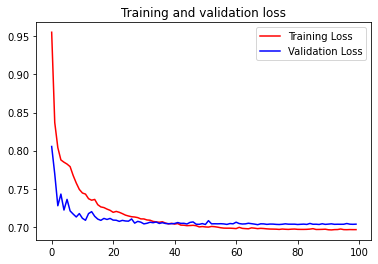

In [36]:
loss = CNN_history.history['loss']
val_loss = CNN_history.history['val_loss']
epochs = range(len(loss))
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [37]:
CNN_predict = CNN_model.predict(inputs_simple[:,:])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



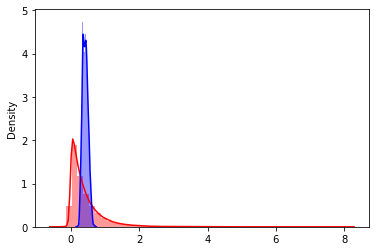

In [51]:
sns.distplot(expected_results[:,:,:], color='red')
sns.distplot(CNN_predict, color='blue')
plt.show()

# GRU et LSTM simple

In [39]:
# prend comme argument le type de modèle L.GRU ou L.LSTM
def build_model(model_type):
    inputs = keras.layers.Input(shape = (68, 14))
    x1 = keras.layers.Bidirectional(model_type(units = 300, dropout = 0.5, return_sequences = True))(inputs)
    x2 = keras.layers.Bidirectional(model_type(units = 150, dropout = 0.5, return_sequences = True))(x1)
    x3 = keras.layers.Bidirectional(model_type(units = 70,  dropout = 0.5, return_sequences = True))(x2)
    out_layer = keras.layers.Dense(3, activation = 'linear')(x3)

    model = tf.keras.Model(inputs = inputs, outputs = out_layer)
    model.compile(tf.keras.optimizers.Adam(), loss = 'mse', metrics = [MCRMSE]) 
    return model

In [40]:
biLSTM_model = build_model(keras.layers.LSTM)
biLSTM_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 68, 14)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 68, 600)           756000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 68, 300)           901200    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 68, 140)           207760    
_________________________________________________________________
dense_7 (Dense)              (None, 68, 3)             423       
Total params: 1,865,383
Trainable params: 1,865,383
Non-trainable params: 0
_________________________________________________________________


In [41]:
biGRU_model = build_model(keras.layers.GRU)
biGRU_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 68, 14)]          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 68, 600)           568800    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 68, 300)           676800    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 68, 140)           156240    
_________________________________________________________________
dense_8 (Dense)              (None, 68, 3)             423       
Total params: 1,402,263
Trainable params: 1,402,263
Non-trainable params: 0
_________________________________________________________________


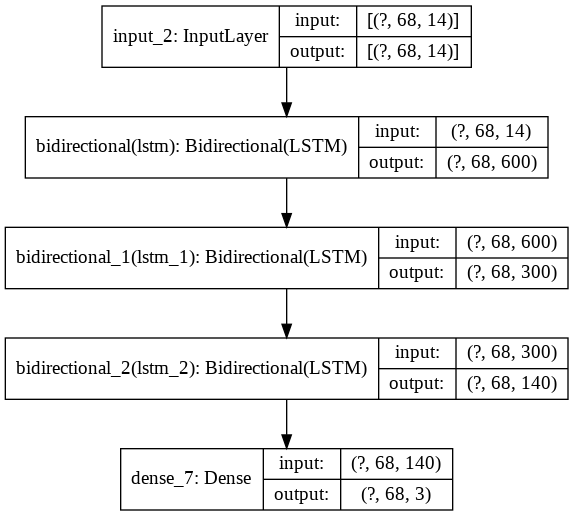

In [42]:
plot_model(biLSTM_model, show_shapes=True)

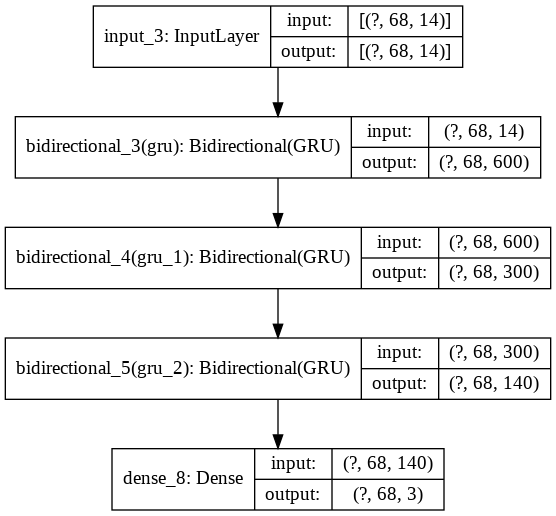

In [43]:
plot_model(biGRU_model, show_shapes=True)

In [44]:
callback = [tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10), 
            tf.keras.callbacks.ModelCheckpoint('biGRU.h5'),
            tf.keras.callbacks.ReduceLROnPlateau(patience=5)]

In [45]:
biLSTM_history = biLSTM_model.fit(
    inputs_simple[:,:68], expected_results,
    batch_size=64,
    epochs=100,
    validation_split = 0.2,
    callbacks = callback,
    verbose=1,
)

Epoch 1/100
20/20 [==============================] - 3s 139ms/step - loss: 0.2327 - MCRMSE: 0.4783 - val_loss: 0.1815 - val_MCRMSE: 0.4242
Epoch 2/100
20/20 [==============================] - 1s 45ms/step - loss: 0.1774 - MCRMSE: 0.4194 - val_loss: 0.1627 - val_MCRMSE: 0.4012
Epoch 3/100
20/20 [==============================] - 1s 43ms/step - loss: 0.1649 - MCRMSE: 0.4038 - val_loss: 0.1537 - val_MCRMSE: 0.3896
Epoch 4/100
20/20 [==============================] - 1s 43ms/step - loss: 0.1590 - MCRMSE: 0.3967 - val_loss: 0.1512 - val_MCRMSE: 0.3863
Epoch 5/100
20/20 [==============================] - 1s 44ms/step - loss: 0.1553 - MCRMSE: 0.3918 - val_loss: 0.1464 - val_MCRMSE: 0.3801
Epoch 6/100
20/20 [==============================] - 1s 44ms/step - loss: 0.1528 - MCRMSE: 0.3887 - val_loss: 0.1424 - val_MCRMSE: 0.3749
Epoch 7/100
20/20 [==============================] - 1s 62ms/step - loss: 0.1489 - MCRMSE: 0.3836 - val_loss: 0.1394 - val_MCRMSE: 0.3710
Epoch 8/100
20/20 [==============

In [46]:
biGRU_history = biGRU_model.fit(
    inputs_simple[:,:68], expected_results,
    batch_size=64,
    epochs=100,
    validation_split = 0.2,
    callbacks = callback,
    verbose=1,
)

Epoch 1/100
20/20 [==============================] - 3s 127ms/step - loss: 0.2323 - MCRMSE: 0.4750 - val_loss: 0.1690 - val_MCRMSE: 0.4082
Epoch 2/100
20/20 [==============================] - 1s 39ms/step - loss: 0.1773 - MCRMSE: 0.4187 - val_loss: 0.1544 - val_MCRMSE: 0.3906
Epoch 3/100
20/20 [==============================] - 1s 38ms/step - loss: 0.1659 - MCRMSE: 0.4050 - val_loss: 0.1513 - val_MCRMSE: 0.3866
Epoch 4/100
20/20 [==============================] - 1s 38ms/step - loss: 0.1607 - MCRMSE: 0.3988 - val_loss: 0.1446 - val_MCRMSE: 0.3780
Epoch 5/100
20/20 [==============================] - 1s 38ms/step - loss: 0.1548 - MCRMSE: 0.3910 - val_loss: 0.1403 - val_MCRMSE: 0.3725
Epoch 6/100
20/20 [==============================] - 1s 39ms/step - loss: 0.1504 - MCRMSE: 0.3857 - val_loss: 0.1333 - val_MCRMSE: 0.3630
Epoch 7/100
20/20 [==============================] - 1s 39ms/step - loss: 0.1451 - MCRMSE: 0.3788 - val_loss: 0.1298 - val_MCRMSE: 0.3584
Epoch 8/100
20/20 [==============

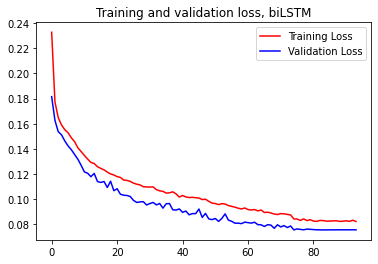

In [52]:
loss = biLSTM_history.history['loss']
val_loss = biLSTM_history.history['val_loss']
epochs = range(len(loss))
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss, biLSTM')

plt.legend()
plt.show()

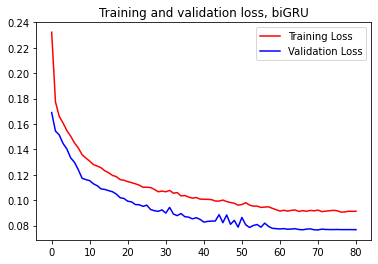

In [53]:
loss = biGRU_history.history['loss']
val_loss = biGRU_history.history['val_loss']
epochs = range(len(loss))
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss, biGRU')

plt.legend()
plt.show()

In [54]:
biGRU_predict = biGRU_model.predict(inputs_simple[:,:68])
biLSTM_predict = biLSTM_model.predict(inputs_simple[:,:68])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



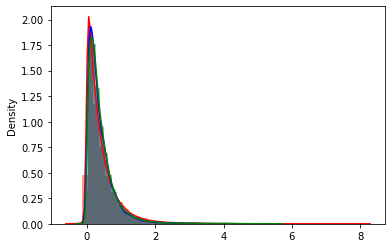

In [55]:
sns.distplot(expected_results[:,:,:], color = 'red')
sns.distplot(biGRU_predict, color='blue')
sns.distplot(biLSTM_predict, color='green')
plt.show()

### **Probleme : ne peut pas predire les autres positions**  
### **Choix de GRU car plus simple et resultats comparables**  
  
# Ajout du masking pour prediction totale

In [56]:
def build_subopt_gru(output_length, input_shape = (130,14), 
              space_dropout = 0.2, 
              masking_val = np.float32(-10)) :
    
    
    
    opt = tf.keras.optimizers.Adam()

    inputs = keras.layers.Input(shape = input_shape)
    mask   = keras.layers.Masking(mask_value=np.float32(masking_val))(inputs)
    mask   = keras.layers.SpatialDropout1D(space_dropout)(mask)
    
    x1 = keras.layers.Bidirectional(keras.layers.GRU(units = 300, dropout = 0.5, return_sequences = True))(mask)
    
    x2 = keras.layers.Bidirectional(keras.layers.GRU(units = 150, dropout = 0.5, return_sequences = True))(x1)
    x3 = keras.layers.Bidirectional(keras.layers.GRU(units = 70,  dropout = 0.5, return_sequences = True))(x2)
    
    # cut masking values
    sliced_layer = x3[:, :output_length]
    out_layer = keras.layers.Dense(3, activation = 'linear')(sliced_layer)
    
    model_gru = tf.keras.Model(inputs = inputs, outputs = out_layer)
    model_gru.compile(opt, loss = 'mse', metrics = [MCRMSE]) #MCRMSE pour kaggle
    
    return model_gru

In [57]:
subopt_model = build_subopt_gru(output_length = 68)
subopt_model.summary()

callback = [tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10), 
            tf.keras.callbacks.ModelCheckpoint('subopt.h5'),
            tf.keras.callbacks.ReduceLROnPlateau(patience=5)]

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 130, 14)]         0         
_________________________________________________________________
masking (Masking)            (None, 130, 14)           0         
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 130, 14)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 130, 600)          568800    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 130, 300)          676800    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 130, 140)          156240    
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, 68, 140)]        

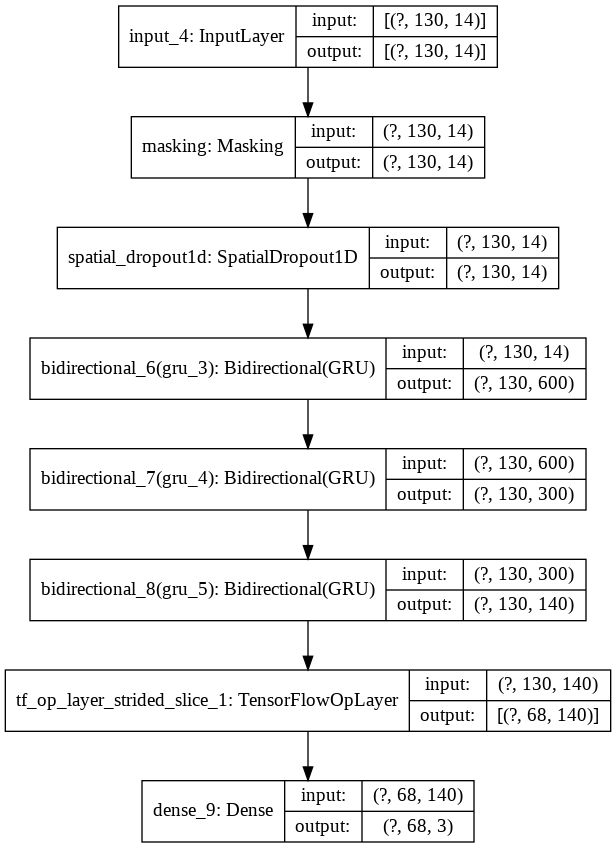

In [58]:
plot_model(subopt_model, show_shapes=True)

In [59]:
subopt_history = subopt_model.fit(
    inputs_simple, expected_results,
    batch_size=64,
    epochs=100,
    validation_split = 0.2,
    callbacks = callback,
    verbose=1,
)

Epoch 1/100
20/20 [==============================] - 7s 354ms/step - loss: 0.2424 - MCRMSE: 0.4861 - val_loss: 0.1681 - val_MCRMSE: 0.4075
Epoch 2/100
20/20 [==============================] - 1s 74ms/step - loss: 0.1863 - MCRMSE: 0.4296 - val_loss: 0.1630 - val_MCRMSE: 0.4012
Epoch 3/100
20/20 [==============================] - 1s 70ms/step - loss: 0.1764 - MCRMSE: 0.4180 - val_loss: 0.1553 - val_MCRMSE: 0.3920
Epoch 4/100
20/20 [==============================] - 1s 72ms/step - loss: 0.1699 - MCRMSE: 0.4102 - val_loss: 0.1515 - val_MCRMSE: 0.3870
Epoch 5/100
20/20 [==============================] - 1s 73ms/step - loss: 0.1645 - MCRMSE: 0.4038 - val_loss: 0.1470 - val_MCRMSE: 0.3813
Epoch 6/100
20/20 [==============================] - 1s 71ms/step - loss: 0.1601 - MCRMSE: 0.3980 - val_loss: 0.1396 - val_MCRMSE: 0.3715
Epoch 7/100
20/20 [==============================] - 1s 74ms/step - loss: 0.1563 - MCRMSE: 0.3934 - val_loss: 0.1364 - val_MCRMSE: 0.3675
Epoch 8/100
20/20 [==============

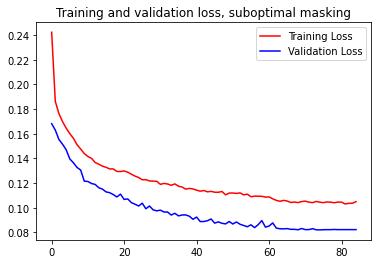

In [60]:
loss = subopt_history.history['loss']
val_loss = subopt_history.history['val_loss']
epochs = range(len(loss))
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss, suboptimal masking')

plt.legend()
plt.show()

In [61]:
subopt_model_pred = build_subopt_gru(107)
subopt_model_pred.load_weights('subopt.h5')

subopt_predict = subopt_model_pred.predict(inputs_simple)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



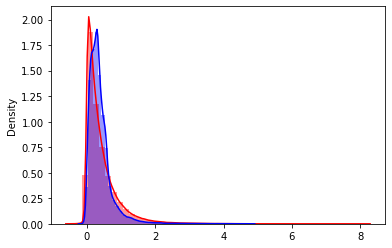

In [62]:
sns.distplot(expected_results[:,:,:], color='red')
sns.distplot(subopt_predict, color='blue')
plt.show()

## Ajout des poids et Choix de learning rate

In [63]:
def build_gru(output_length, lr, input_shape = (130,14), 
              space_dropout = 0.2, 
              masking_val = np.float32(-10)) :
    
    
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    inputs = keras.layers.Input(shape = input_shape)
    mask   = keras.layers.Masking(mask_value=np.float32(masking_val))(inputs)
    mask   = keras.layers.SpatialDropout1D(space_dropout)(mask)
    
    x1 = keras.layers.Bidirectional(keras.layers.GRU(units = 300, dropout = 0.5, return_sequences = True))(mask)
    
    x2 = keras.layers.Bidirectional(keras.layers.GRU(units = 150, dropout = 0.5, return_sequences = True))(x1)
    x3 = keras.layers.Bidirectional(keras.layers.GRU(units = 70,  dropout = 0.5, return_sequences = True))(x2)
    
    # cut masking values
    sliced_layer = x3[:, :output_length]
    out_layer = keras.layers.Dense(3, activation = 'linear')(sliced_layer)
    
    model_gru = tf.keras.Model(inputs = inputs, outputs = out_layer)
    model_gru.compile(opt, loss = 'mse', metrics = [MCRMSE]) #MCRMSE pour kaggle
    
    return model_gru

#### lr models

In [ ]:
##### LR = 0.00000001 #######

model_9 = build_gru(output_length = 68, lr = 0.000000001)
history_9 = model_9.fit(
    inputs_simple, expected_results,
    batch_size=64,
    epochs=50,
    validation_split = 0.2,
    shuffle = True,
    verbose=0)

In [ ]:
##### LR = 0.0000001 #######

model_8 = build_gru(output_length = 68, lr = 0.00000001)
history_8 = model_8.fit(
    inputs_simple, expected_results,
    batch_size=64,
    epochs=50,
    validation_split = 0.2,
    shuffle = True,
    verbose=0)

In [ ]:
##### LR = 0.000001 #######

model_7 = build_gru(output_length = 68, lr = 0.0000001)
history_7 = model_7.fit(
    inputs_simple, expected_results,
    batch_size=64,
    epochs=50,
    validation_split = 0.2,
    shuffle = True,
    verbose=0)

In [ ]:
##### LR = 0.000001 #######

model_6 = build_gru(output_length = 68, lr = 0.000001)
history_6 = model_6.fit(
    inputs_simple, expected_results,
    batch_size=64,
    epochs=50,
    validation_split = 0.2,
    shuffle = True,
    verbose=0)

In [ ]:
##### LR = 0.00001 #######

model_5 = build_gru(output_length = 68, lr = 0.00001)
history_5 = model_5.fit(
    inputs_simple, expected_results,
    batch_size=64,
    epochs=50,
    validation_split = 0.2,
    shuffle = True,
    verbose=0)

In [ ]:
##### LR = 0.0001 #######

model_4 = build_gru(output_length = 68, lr = 0.0001)
history_4 = model_4.fit(
    inputs_simple, expected_results,
    batch_size=64,
    epochs=50,
    validation_split = 0.2,
    shuffle = True,
    verbose=0)

In [ ]:
##### LR = 0.001 #######

model_3 = build_gru(output_length = 68, lr = 0.001)
history_3 = model_3.fit(
    inputs_simple, expected_results,
    batch_size=64,
    epochs=50,
    validation_split = 0.2,
    shuffle = True,
    verbose=0)

In [ ]:
##### LR = 0.01 #######
model_2 = build_gru(output_length = 68, lr = 0.01)
history_2 = model_2.fit(
    inputs_simple, expected_results,
    batch_size=64,
    epochs=50,
    validation_split = 0.2,
    shuffle = True,
    verbose=0)

In [ ]:
##### LR = 0.1 #######
model_1 = build_gru(output_length = 68, lr = 0.1)
history_1 = model_1.fit(
    inputs_simple, expected_results,
    batch_size=64,
    epochs=50,
    validation_split = 0.2,
    shuffle = True,
    verbose=0)

In [ ]:
##### LR = 1 #######
model_0 = build_gru(output_length = 68, lr = 1)
history_0 = model_0.fit(
    inputs_simple, expected_results,
    batch_size=64,
    epochs=50,
    validation_split = 0.2,
    shuffle = True,
    verbose=0)

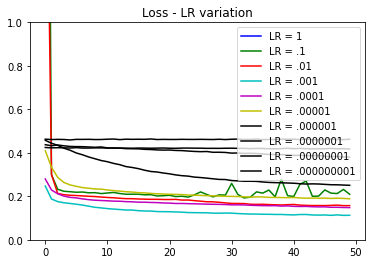

In [ ]:
loss0 = history_0.history['loss']
loss1 = history_1.history['loss']
loss2 = history_2.history['loss']
loss3 = history_3.history['loss']
loss4 = history_4.history['loss']
loss5 = history_5.history['loss']
loss6 = history_6.history['loss']
loss7 = history_7.history['loss']
loss8 = history_8.history['loss']
loss9 = history_9.history['loss']

epochs = range(len(loss0))
plt.figure()

plt.plot(epochs, loss0, 'b', label='LR = 1')
plt.plot(epochs, loss1, 'g', label='LR = .1')
plt.plot(epochs, loss2, 'r', label='LR = .01')
plt.plot(epochs, loss3, 'c', label='LR = .001')
plt.plot(epochs, loss4, 'm', label='LR = .0001')
plt.plot(epochs, loss5, 'y', label='LR = .00001')
plt.plot(epochs, loss6, 'k', label='LR = .000001')
plt.plot(epochs, loss7, 'k', label='LR = .0000001')
plt.plot(epochs, loss8, 'k', label='LR = .00000001')
plt.plot(epochs, loss9, 'k', label='LR = .000000001')

plt.title('Loss - LR variation')
axes = plt.gca()
axes.set_ylim(0, 1)

plt.legend()
plt.show()

#### End lr models

In [64]:
clusters = files.upload()

Saving outputraw1587.txt.clstr to outputraw1587.txt.clstr


In [65]:
def extract_clusters(clstr_file):
    """Extract clusters from .clstr file and return a dict 
    with keys = clusters and dict[key] = [clustersize,[sequences]]
    """
    with open(clstr_file,'r') as file:
        cluster = {}
        sequences = []
        clusternum = 1
        entiers = ["0","1","2","3","4","5","6","7","8","9"]
        clustsize = 0
        rmb = 0
        for line in file:
            if line[0] != '>':
                rmb += 1
                if rmb > 9:
                    clustsize = int(line[0:2]) + 1
                    seq = line[14:18]
                else:
                    clustsize = int(line[0]) + 1
                    seq = line[13:17]
                for i,let in enumerate(seq):
                    if let not in entiers:
                        seq = seq[0:i]
                        break
                sequences.append(seq)
            else :
                if clustsize >= 0:
                    cluster[clusternum] = [clustsize,sequences]
                    clusternum += 1
                sequences = []
                rmb = 0
    return cluster

def construct_weight(clustering,dim_vector):
    """Construct the weight vector from a dict
    """
    weights = list(range(dim_vector))
    for key in clustering.keys():
        if key == 0:
            continue
        for numseq in clustering[key][1]:
            weights[int(numseq)-1] = float(1/clustering[key][0])
    return weights

In [66]:
clustering = extract_clusters('outputraw1587.txt.clstr') #remplace par le nom de ton fichier dans ton répertoire local ( *.txt.clstr )
weights = construct_weight(clustering, train.shape[0])

In [67]:
callback = [tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10), 
            tf.keras.callbacks.ModelCheckpoint('weighed.h5'),
            tf.keras.callbacks.ReduceLROnPlateau(patience=5)]

weighed_model = build_gru(output_length = 68, lr = 0.001)
weighed_history = weighed_model.fit(
    inputs_simple, expected_results,
    batch_size=64,
    epochs=100,
    validation_split = 0.2,
    callbacks = callback,
    shuffle = True,
    verbose=1,
    sample_weight=np.array(weights) #poids rajoute, a voir si mieux avec ou sans
)

Epoch 1/100
20/20 [==============================] - 7s 342ms/step - loss: 0.4748 - MCRMSE: 0.5450 - val_loss: 1.1877 - val_MCRMSE: 0.4715
Epoch 2/100
20/20 [==============================] - 1s 75ms/step - loss: 0.3422 - MCRMSE: 0.4710 - val_loss: 0.9607 - val_MCRMSE: 0.4384
Epoch 3/100
20/20 [==============================] - 1s 70ms/step - loss: 0.3837 - MCRMSE: 0.5375 - val_loss: 1.4751 - val_MCRMSE: 0.5791
Epoch 4/100
20/20 [==============================] - 1s 71ms/step - loss: 0.3671 - MCRMSE: 0.5078 - val_loss: 0.9812 - val_MCRMSE: 0.4604
Epoch 5/100
20/20 [==============================] - 2s 78ms/step - loss: 0.3795 - MCRMSE: 0.5024 - val_loss: 0.8705 - val_MCRMSE: 0.4265
Epoch 6/100
20/20 [==============================] - 1s 70ms/step - loss: 0.3098 - MCRMSE: 0.4582 - val_loss: 0.8078 - val_MCRMSE: 0.4201
Epoch 7/100
20/20 [==============================] - 1s 70ms/step - loss: 0.3255 - MCRMSE: 0.4660 - val_loss: 1.2103 - val_MCRMSE: 0.4616
Epoch 8/100
20/20 [==============

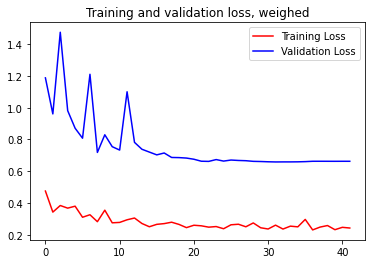

In [68]:
loss = weighed_history.history['loss']
val_loss = weighed_history.history['val_loss']
epochs = range(len(loss))
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss, weighed')

plt.legend()
plt.show()

In [69]:
weighed_model_pred = build_gru(107, 0.001)
weighed_model_pred.load_weights('weighed.h5')

weighed_predict = weighed_model_pred.predict(inputs_simple)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



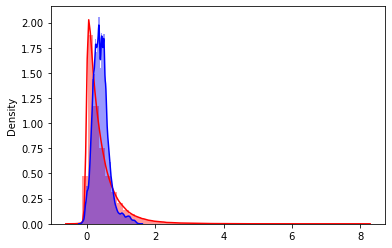

In [70]:
sns.distplot(expected_results[:,:,:], color='red')
sns.distplot(weighed_predict, color='blue')
plt.show()

In [ ]:
#Creation of function that gives train and test set indexes from a pandas dataframe
def data_sep(dataset, data_size, train_size):
    train = random.sample(range(data_size), train_size)
    test = list(range(0,data_size))
    for i in train:
        test.remove(i)
    return(train,test)

In [ ]:
inputs = inputs_simple
targets = expected_results

num_folds = 10
fold_no = 1

while fold_no <= num_folds:
    kf_train_index, kf_test_index = data_sep(train,1587,1300)
    train_in = inputs[kf_train_index, ]
    test_in = inputs[kf_test_index, ]
    train_out = targets[kf_train_index, ]
    test_out = targets[kf_test_index, ]

    kf_model = build_gru(output_length = 68, lr=0.001)
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    # Fit data to model
    history = kf_model.fit(train_in, train_out, batch_size=100, epochs=30, verbose=0)
    
  
    # Generate generalization metrics
    scores = kf_model.evaluate(test_in, test_out, verbose=0)
    print(f'Score for fold {fold_no}: {kf_model.metrics_names[0]} of {scores[0]}\n\
    and {kf_model.metrics_names[1]} of {scores[1]}')
    fold_no+=1

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.10964107513427734
    and MCRMSE of 0.3292960226535797
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.10401163250207901
    and MCRMSE of 0.3207336366176605
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.10251075774431229
    and MCRMSE of 0.31798961758613586
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.10369887202978134
    and MCRMSE of 0.3204885721206665
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.10175517946481705
    and MCRMSE of 0.3175935447216034
------------------------------------------------------------------------
Training for fold 6 ...
Sc